In [1]:
#Dataset and label file loading

import pandas as pd
import os

# Load the label.lst file
labels_path = '/kaggle/input/label-lst/label.lst'
labels_df = pd.read_csv(labels_path, delim_whitespace=True, header=None)

# Assign column names based on the format of label.lst
labels_df.columns = ['filename', 'emotion', 'x1', 'y1', 'x2', 'y2', 'confidence', 'unused']

# Check the first few rows to ensure it's loaded correctly
print(labels_df.head())

# Define the path to the image folder
image_folder = '/kaggle/input/origin-expw/origin'

# Add a new column with the full path to each image file
labels_df['filepath'] = labels_df['filename'].apply(lambda x: os.path.join(image_folder, x))

# Check the updated DataFrame
print(labels_df.head())


/tmp/ipykernel_30/676321109.py:8: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  labels_df = pd.read_csv(labels_path, delim_whitespace=True, header=None)


              filename  emotion  x1   y1   x2   y2  confidence  unused
0  angry_actor_104.jpg        0  28  113  226  141     22.9362       0
1  angry_actor_109.jpg        0  31  157  345  219     50.3056       0
2  angry_actor_120.jpg        1  53   53  372  372     13.9434       2
3   angry_actor_13.jpg        0  77   51  362  388     85.8104       3
4  angry_actor_132.jpg        0  95   31  412  476     82.3948       0
              filename  emotion  x1   y1   x2   y2  confidence  unused  \
0  angry_actor_104.jpg        0  28  113  226  141     22.9362       0   
1  angry_actor_109.jpg        0  31  157  345  219     50.3056       0   
2  angry_actor_120.jpg        1  53   53  372  372     13.9434       2   
3   angry_actor_13.jpg        0  77   51  362  388     85.8104       3   
4  angry_actor_132.jpg        0  95   31  412  476     82.3948       0   

                                            filepath  
0  /kaggle/input/origin-expw/origin/angry_actor_1...  
1  /kaggle/input/or

In [2]:
from sklearn.model_selection import train_test_split

# Filter out unwanted labels
filtered_labels_df = labels_df[labels_df['emotion'].isin([0, 1, 2, 3, 4, 5, 6])]

# Now perform the train-test split on the filtered data
train_val_df, test_df = train_test_split(filtered_labels_df, test_size=0.15, stratify=filtered_labels_df['emotion'], random_state=42)

# Further split train+val into train and validation sets
train_df, val_df = train_test_split(train_val_df, test_size=0.1765, stratify=train_val_df['emotion'], random_state=42) # 0.1765 to get 15% of total as val

# Check the splits
print(f"Training set: {len(train_df)} samples")
print(f"Validation set: {len(val_df)} samples")
print(f"Test set: {len(test_df)} samples")


Training set: 62884 samples
Validation set: 13478 samples
Test set: 13476 samples


In [3]:
print("Training labels:", train_df['emotion'].unique())
print("Validation labels:", val_df['emotion'].unique())
print("Test labels:", test_df['emotion'].unique())


Training labels: [2 1 0 3 5 6 4]
Validation labels: [1 3 0 5 4 2 6]
Test labels: [0 2 1 3 5 4 6]


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Define a single ImageDataGenerator with validation split
datagen = ImageDataGenerator(
    rescale=1./255,               # Rescale pixel values from [0, 255] to [0, 1]
    shear_range=0.2,              # Randomly shear the images (augmentation for training only)
    zoom_range=0.2,               # Randomly zoom the images
    horizontal_flip=True,         # Randomly flip the images horizontally
    validation_split=0.2          # 20% of data for validation
)

# Define image size and batch size
IMG_SIZE = (224, 224)  # Adjust according to your model input size
BATCH_SIZE = 32

# Preprocess training data with augmentations and 'raw' class mode for integer labels
train_generator = datagen.flow_from_dataframe(
    dataframe=train_df,            # DataFrame with image data
    directory=image_folder,        # Image directory
    x_col='filename',              # Column containing image filenames
    y_col='emotion',               # Column containing integer labels
    target_size=IMG_SIZE,          # Target image size
    batch_size=BATCH_SIZE,         # Batch size
    class_mode='raw',              # 'raw' class mode because labels are integers
    subset='training'              # Use 80% of data for training (due to validation_split=0.2)
)

# Preprocess validation data without augmentations (but still rescaling) using the same datagen
validation_generator = datagen.flow_from_dataframe(
    dataframe=train_df,            # DataFrame with image data
    directory=image_folder,        # Image directory
    x_col='filename',              # Column containing image filenames
    y_col='emotion',               # Column containing integer labels
    target_size=IMG_SIZE,          # Target image size
    batch_size=BATCH_SIZE,         # Batch size
    class_mode='raw',              # 'raw' class mode for integer labels
    subset='validation'            # Use 20% of data for validation (due to validation_split=0.2)
)

# Preprocess test data without augmentations
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,             # DataFrame with test data
    directory=image_folder,        # Image directory
    x_col='filename',              # Column containing image filenames
    y_col='emotion',               # Column containing integer labels
    target_size=IMG_SIZE,          # Target image size
    batch_size=BATCH_SIZE,         # Batch size
    class_mode='raw',              # 'raw' class mode for integer labels
    shuffle=False                  # Don't shuffle test data
)


Found 50308 validated image filenames.
Found 12576 validated image filenames.
Found 13476 validated image filenames.


In [5]:
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNetV2

# Define the input shape for the model (height, width, channels)
IMG_SHAPE = IMG_SIZE + (3,)  # Assuming IMG_SIZE is a tuple like (224, 224)

# Create the base model from the pre-trained MobileNetV2
base_model = MobileNetV2(input_shape=IMG_SHAPE, include_top=False, weights='imagenet')

# Retrieve the next batch of images and their corresponding labels from the training dataset
image_batch, label_batch = next(train_generator)  # Use next directly on the generator
print(f"Image batch shape: {image_batch.shape}, Label batch shape: {label_batch.shape}")  # Print the shapes

# Pass the image batch through the base model (MobileNetV2) to extract features
feature_batch = base_model(image_batch)
print(f"Feature batch shape: {feature_batch.shape}")  # Print the shape of the feature batch


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Image batch shape: (32, 224, 224, 3), Label batch shape: (32,)
Feature batch shape: (32, 7, 7, 1280)


In [7]:
# Freeze the base model layers to prevent them from training initially
base_model.trainable = False

# Define the inputs
inputs = layers.Input(shape=IMG_SHAPE)

# Pass the inputs through the base model
x = base_model(inputs, training=False)

# Add global average pooling and output layers
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(128, activation='relu')(x)
outputs = layers.Dense(7, activation='softmax')(x)  # 7 classes for output

# Create the full model
model = models.Model(inputs, outputs)

# Display the model architecture
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,422,855 (9.24 MB)

 Trainable params: 164,871 (644.03 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [8]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Compile the model
model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',  # Use this for integer labels
              metrics=['accuracy'])

# Set up callbacks
checkpoint_callback = ModelCheckpoint(
    'best_model.keras',  # File path with .keras extension
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save only the best model
    mode='min',  # We want the loss to minimize
    verbose=1  # Display info when a model is saved
)

early_stopping_callback = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,  # Stop if no improvement after 5 epochs
    restore_best_weights=True,  # Restore the best weights at the end
    mode='min',
    verbose=1
)

In [9]:
# Train the model
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=5,  # Set the maximum number of epochs as needed
    callbacks=[checkpoint_callback, early_stopping_callback],
    verbose=1
)

# Check the history object for training metrics
print(history.history.keys())  # Display keys in the history obje

Epoch 1/5


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1730088408.034207     101 service.cc:145] XLA service 0x7f9898002650 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1730088408.034264     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1730088408.034270     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   1/1573 ━━━━━━━━━━━━━━━━━━━━ 6:30:46 15s/step - accuracy: 0.1875 - loss: 2.0195

I0000 00:00:1730088413.231938     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1572/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 619ms/step - accuracy: 0.5905 - loss: 1.0390
Epoch 1: val_loss improved from inf to 0.96457, saving model to best_model.keras
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 1231s 774ms/step - accuracy: 0.5905 - loss: 1.0390 - val_accuracy: 0.6031 - val_loss: 0.9646
Epoch 2/5
1572/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step - accuracy: 0.6061 - loss: 0.9596
Epoch 2: val_loss improved from 0.96457 to 0.95543, saving model to best_model.keras
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 926s 587ms/step - accuracy: 0.6061 - loss: 0.9596 - val_accuracy: 0.6038 - val_loss: 0.9554
Epoch 3/5
1572/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6039 - loss: 0.9534
Epoch 3: val_loss did not improve from 0.95543
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 919s 582ms/step - accuracy: 0.6039 - loss: 0.9534 - val_accuracy: 0.6042 - val_loss: 0.9600
Epoch 4/5
1572/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 467ms/step - accuracy: 0.6095 - loss: 0.9386
Epoch 4: val_loss improved from 0.95543 to 0.95485, saving model to bes

In [10]:
# Find the epoch with the best validation loss
best_val_loss_epoch = min(range(len(history.history['val_loss'])), key=lambda i: history.history['val_loss'][i])
# Find the epoch with the best validation accuracy
best_val_accuracy_epoch = max(range(len(history.history['val_accuracy'])), key=lambda i: history.history['val_accuracy'][i])

# Display the results for the epoch with the best validation loss
print(f"Best Epoch by Validation Loss: {best_val_loss_epoch + 1}")
print(f"  - Training Accuracy: {history.history['accuracy'][best_val_loss_epoch]:.4f}")
print(f"  - Validation Accuracy: {history.history['val_accuracy'][best_val_loss_epoch]:.4f}")
print(f"  - Training Loss: {history.history['loss'][best_val_loss_epoch]:.4f}")
print(f"  - Validation Loss: {history.history['val_loss'][best_val_loss_epoch]:.4f}\n")

# Display the results for the epoch with the best validation accuracy
print(f"Best Epoch by Validation Accuracy: {best_val_accuracy_epoch + 1}")
print(f"  - Training Accuracy: {history.history['accuracy'][best_val_accuracy_epoch]:.4f}")
print(f"  - Validation Accuracy: {history.history['val_accuracy'][best_val_accuracy_epoch]:.4f}")
print(f"  - Training Loss: {history.history['loss'][best_val_accuracy_epoch]:.4f}")
print(f"  - Validation Loss: {history.history['val_loss'][best_val_accuracy_epoch]:.4f}")


Best Epoch by Validation Loss: 4
  - Training Accuracy: 0.6095
  - Validation Accuracy: 0.6021
  - Training Loss: 0.9399
  - Validation Loss: 0.9549

Best Epoch by Validation Accuracy: 5
  - Training Accuracy: 0.6088
  - Validation Accuracy: 0.6043
  - Training Loss: 0.9358
  - Validation Loss: 0.9638


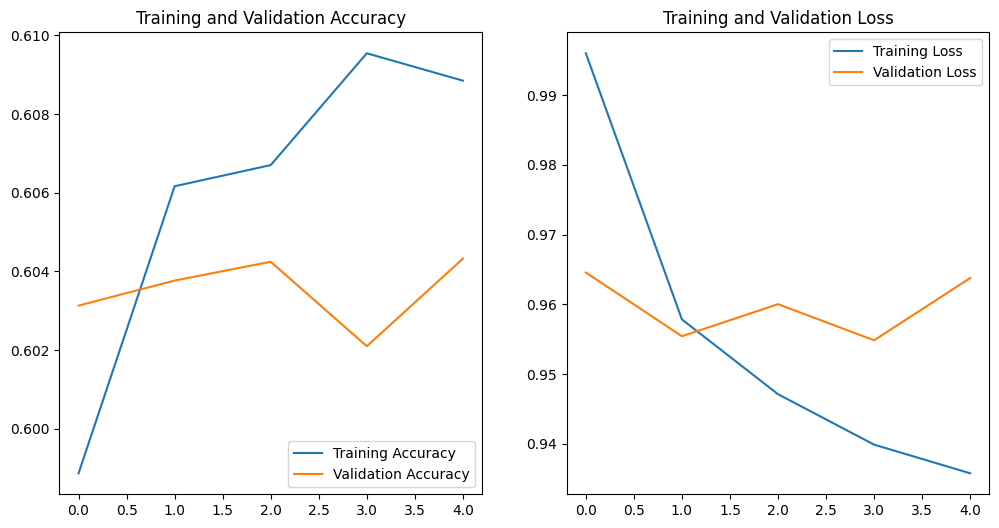

In [11]:
import matplotlib.pyplot as plt

# Retrieve accuracy and loss values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Get the number of epochs
epochs_range = range(len(acc))

# Plot training and validation accuracy
plt.figure(figsize=(12, 6))

# Accuracy subplot
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Loss subplot
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

# Display the plots
plt.show()


In [12]:
from tensorflow.keras.optimizers import Adam

# Unfreeze some of the last layers in the base model
for layer in base_model.layers[-30:]:  # Adjust the number of layers to unfreeze
    layer.trainable = True

# Recompile the model with a lower learning rate for fine-tuning
fine_tune_lr = 1e-5  # Adjust as needed, e.g., 1e-5 to 1e-6
model.compile(optimizer=Adam(learning_rate=fine_tune_lr),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
# Fine-tune the model
fine_tune_epochs = 10  # Number of epochs for fine-tuning
history_fine_tune = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=fine_tune_epochs,
    initial_epoch=4,  # Continue from Epoch 4
    callbacks=[checkpoint_callback, early_stopping_callback]
)


Epoch 5/10
1572/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step - accuracy: 0.6093 - loss: 0.9893
Epoch 5: val_loss did not improve from 0.95485
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 952s 594ms/step - accuracy: 0.6093 - loss: 0.9893 - val_accuracy: 0.6034 - val_loss: 0.9577
Epoch 6/10
1572/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 466ms/step - accuracy: 0.6141 - loss: 0.9259
Epoch 6: val_loss improved from 0.95485 to 0.94067, saving model to best_model.keras
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 926s 586ms/step - accuracy: 0.6141 - loss: 0.9259 - val_accuracy: 0.6058 - val_loss: 0.9407
Epoch 7/10
1572/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step - accuracy: 0.6124 - loss: 0.9093
Epoch 7: val_loss improved from 0.94067 to 0.92917, saving model to best_model.keras
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 929s 588ms/step - accuracy: 0.6124 - loss: 0.9093 - val_accuracy: 0.5985 - val_loss: 0.9292
Epoch 8/10
1573/1573 ━━━━━━━━━━━━━━━━━━━━ 0s 463ms/step - accuracy: 0.6162 - loss: 0.8906
Epoch 8: val_loss improved from 0.92917 to 0.92596, sa

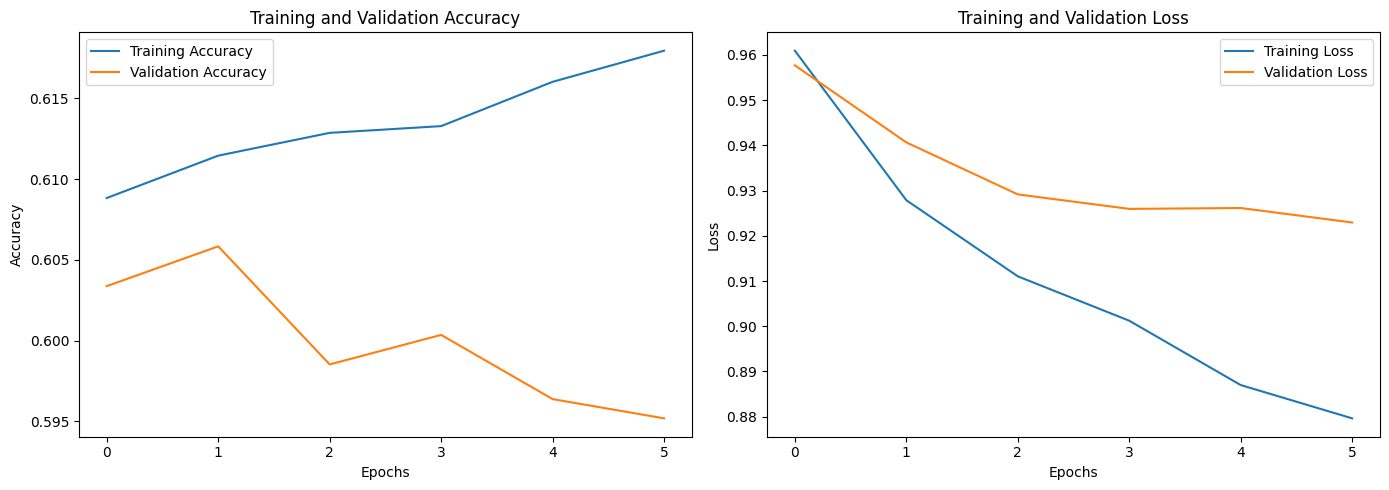

In [15]:
import matplotlib.pyplot as plt

# Combine histories if you have separate history objects
# training_history can be merged if you saved both pre-fine-tuning and fine-tuning results
history_dict = {**history.history, **history_fine_tune.history}

# Plot Training and Validation Accuracy
plt.figure(figsize=(14, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Training Accuracy')
plt.plot(history_dict['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Plot Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Training Loss')
plt.plot(history_dict['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [16]:
loss, accuracy = model.evaluate(test_generator)  # Evaluate the model on the test dataset, returning loss and accuracy
print('Test accuracy :', accuracy)  # Print the accuracy obtained from the test dataset


422/422 ━━━━━━━━━━━━━━━━━━━━ 127s 300ms/step - accuracy: 0.5912 - loss: 0.9310
Test accuracy : 0.5972840785980225


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


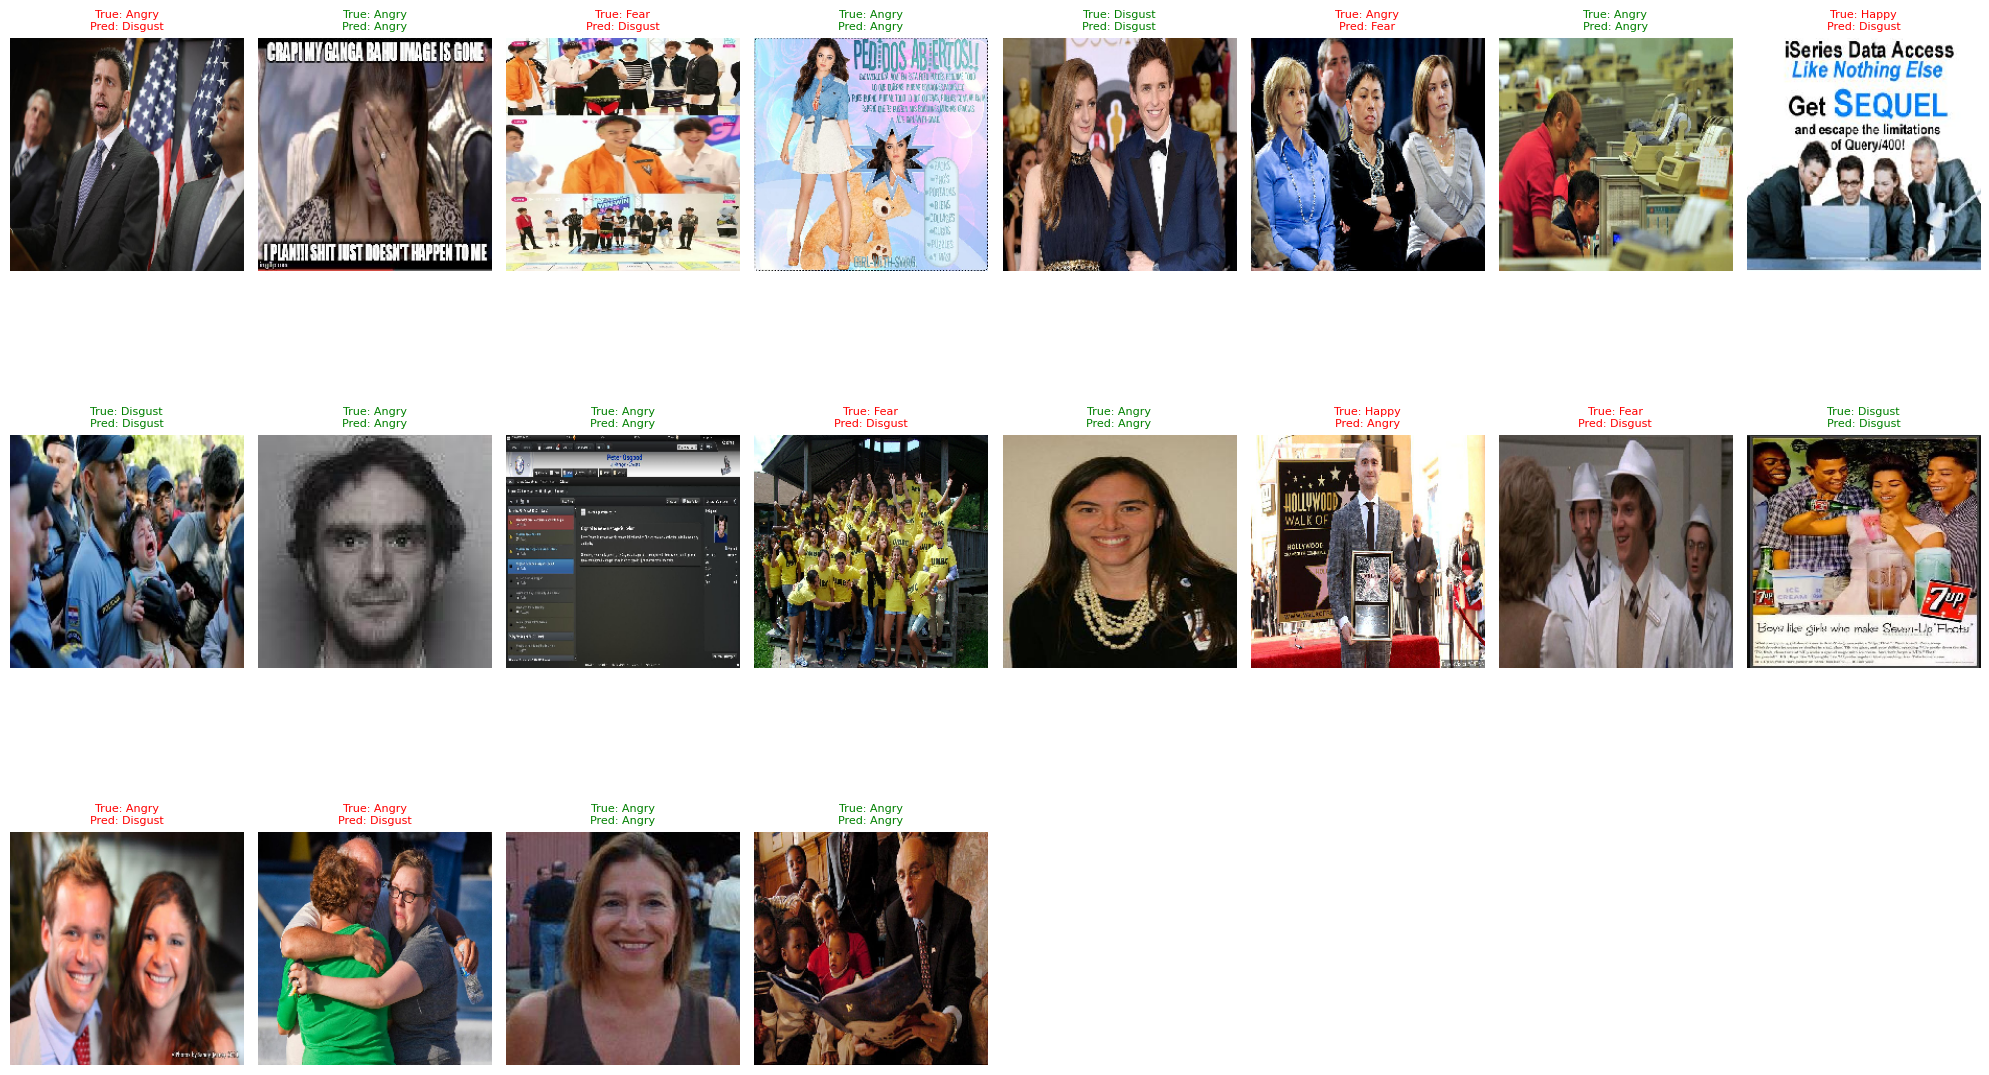

In [17]:
import matplotlib.pyplot as plt
import numpy as np

def display_predictions(model, generator, class_names, num_images=30):
    """
    Displays a grid of images with their true and predicted labels using an ImageDataGenerator.
    """
    images, labels = next(generator)  # Get a batch of images and labels from the generator
    predictions = model.predict(images)
    predictions = np.argmax(predictions, axis=1)  # Convert predictions to label indices
    
    # Rescale images if they are in the range [0, 1] for display purposes
    if images.max() <= 1.0:
        images = (images * 255).astype("uint8")
    
    plt.figure(figsize=(20, 20))  # Increase figure size for clarity
    rows = 5
    cols = 8  # 5x8 grid for 40 images

    for i in range(num_images):
        ax = plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        true_label = class_names[labels[i]]
        pred_label = class_names[predictions[i]]
        color = "green" if predictions[i] == labels[i] else "red"
        plt.title(f"True: {true_label}\nPred: {pred_label}", color=color, fontsize=8)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Define class names and call the display function
class_names = ['Angry', 'Disgust', 'Fear', 'Happy', 'Sad', 'Surprise', 'Neutral']
display_predictions(model, test_generator, class_names, num_images=20)


In [21]:
import numpy as np

# Predict labels for the test dataset
predictions = model.predict(test_generator)
predicted_labels = np.argmax(predictions, axis=1)
# true_labels = test_generator.classes  # True labels for the test dataset

true_labels = test_generator.labels  # True labels for the test dataset



422/422 ━━━━━━━━━━━━━━━━━━━━ 64s 151ms/step


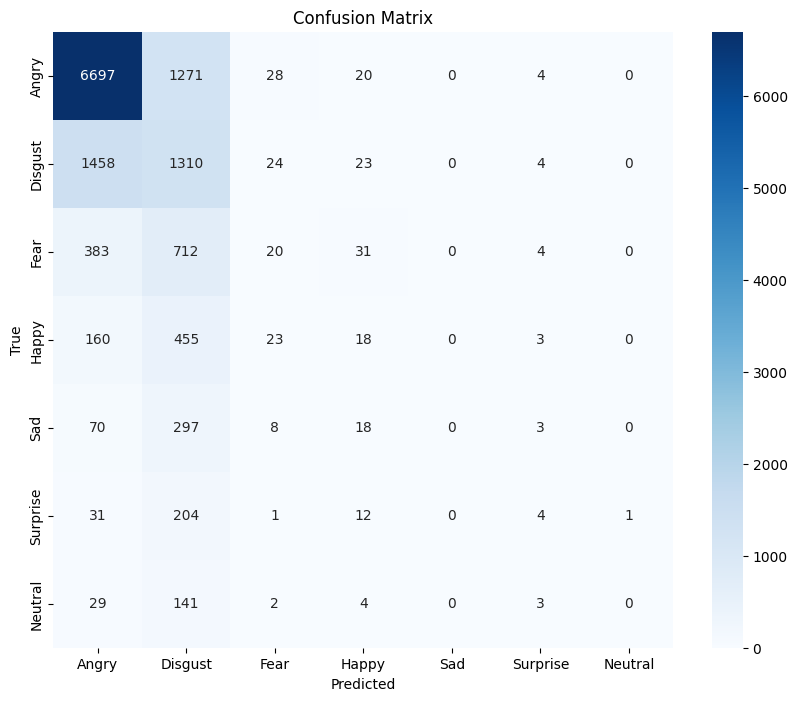

              precision    recall  f1-score   support

       Angry       0.76      0.84      0.79      8020
     Disgust       0.30      0.46      0.36      2819
        Fear       0.19      0.02      0.03      1150
       Happy       0.14      0.03      0.05       659
         Sad       0.00      0.00      0.00       396
    Surprise       0.16      0.02      0.03       253
     Neutral       0.00      0.00      0.00       179

    accuracy                           0.60     13476
   macro avg       0.22      0.19      0.18     13476
weighted avg       0.54      0.60      0.55     13476



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
from sklearn.metrics import classification_report, confusion_matrix

# Generate confusion matrix and classification report
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

print(classification_report(true_labels, predicted_labels, target_names=class_names))
